In [161]:
from src.util import read_results
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
result_df = read_results(from_parquet=True)
result_df.head()

,dataset,speedup,operator,num_cores,selectivity,cardinality_T,cardinality_S,join,compute_unit,complexity_ratio,...,cache_size_l2,clock_speed_base,clock_speed_max_boost,memory_bus_width,memory_size,memory_clock,memory_bandwidth,processing_power_half_precision,processing_power_single_precision,processing_power_double_precision
8,n_R=1-r_T=500000-c_T=10-rho_c_S=0.1-rho_c_R=0....,35.682223,Left multiply,8,1.005264,500000,502632,preset,CPU 08c,9.54767,...,None,None,None,None,None,None,None,None,None,None
9,n_R=1-r_T=500000-c_T=10-rho_c_S=0.1-rho_c_R=0....,16.784362,Left multiply,32,1.005264,500000,502632,preset,CPU 32c,9.54767,...,None,None,None,None,None,None,None,None,None,None
10,n_R=1-r_T=500000-c_T=10-rho_c_S=0.1-rho_c_R=0....,9.881361,Left multiply,16,1.005264,500000,502632,preset,CPU 16c,9.54767,...,None,None,None,None,None,None,None,None,None,None
11,n_R=1-r_T=500000-c_T=10-rho_c_S=0.1-rho_c_R=0....,0.242405,Left multiply,-1,1.005264,500000,502632,preset,1080,9.54767,...,2.8,1480,1582,352,11,11000,484,0.17,10.61,0.33
12,n_R=1-r_T=500000-c_T=10-rho_c_S=0.1-rho_c_R=0....,0.211488,Left multiply,-1,1.005264,500000,502632,preset,v100,9.54767,...,6.2,1230,1370,4096,32,1750,900,112.22,14.03,7.01


In [163]:
result_df.columns

Index(['dataset', 'speedup', 'operator', 'num_cores', 'selectivity',
       'cardinality_T', 'cardinality_S', 'join', 'compute_unit',
       'complexity_ratio', 'times_mean', 'source_file', 'dataset_type',
       'compute_type', 'label', 'features', 'parallelism', 'mem_mat_read',
       'mem_mat_write', 'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat',
       'comp_lmm_mat', 'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac',
       'comp_rmm_fac', 'comp_mat_col_major', 'comp_fac_col_major',
       'comp_scalar_dense', '13', '14', 'comp_matrix_dense',
       'mem_read_scalar_dense', 'mem_write_scalar_dense',
       'mem_read_matrix_dense', 'mem_write_matrix_dense', 'mem_read_rowsum',
       'mem_write_rowsum', 'mem_read_colsum', 'mem_write_colsum', '24', '25',
       'comp_rowsum', 'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio',
       'tr', 'fr', 'r_S', 'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S',
       'r_T', 'c_T', 'sparsity_T', 'sparsity_S', 'morpheusfi_p',
       'morp

In [169]:
def train_test_validate_split(df, test_fraction=0.3):
    df = df.copy()
    df.drop(columns=['dataset', 'speedup', 'source_file'], inplace=True)
    gpu_col = 'compute_unit'
    assert 'p100' in df[gpu_col].unique()
    validate = df[(df['compute_unit'] == 'p100') | (df['dataset_type'] != 'synthetic')]
    train, test = train_test_split(df[~df.index.isin(validate.index)], test_size=test_fraction)
    return train, test, validate

In [170]:
train, test, validate = train_test_validate_split(result_df)

def describe(df, name):
    print(f"{name} set:")
    print(f"\tRecords: {len(df)}")
    pos, neg = len(df[df.label]), len(df[~df.label])
    print(f"\tPositive (speedup > 1 with factorizing)/Negative: {pos}/{neg} = {pos/neg:.2f} s")
    print(f"\tDataset types: {df.dataset_type.unique()}")
    print(f"\Compute Units: {df.compute_unit.unique()}")

describe(train, 'train')
describe(test, 'test')
describe(validate, 'validate')


train set:
	Records: 189256
	Positive (speedup > 1 with factorizing)/Negative: 36510/152746 = 0.24 s
	Dataset types: ['synthetic']
\Compute Units: ['2080' '1080' 'CPU 16c' 'v100' 'a40' 'CPU 08c' 'CPU 32c']
test set:
	Records: 81110
	Positive (speedup > 1 with factorizing)/Negative: 15464/65646 = 0.24 s
	Dataset types: ['synthetic']
\Compute Units: ['1080' '2080' 'CPU 32c' 'CPU 16c' 'a40' 'v100' 'CPU 08c']
validate set:
	Records: 42183
	Positive (speedup > 1 with factorizing)/Negative: 5569/36614 = 0.15 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [171]:
model_features = [
    "cardinality_S",
    "cardinality_T",
    "comp_lmm_fac",
    "comp_lmm_mat",
    "comp_ratio",
    "comp_scalar_dense",
    "fr",
    # "GPU",
    "mem_write_rowsum",
    "nnz_S_sum", "nnz_T",
    "operator",
    "r_T", "c_T",
    # "r_S", "c_S",
    "selectivity",
    "sparsity_T",
    "tr",
    'memory_bandwidth',
    '_cores', 
    'processing_power_double_precision'
]
X_train, y_train = train[model_features], train["label"]
X_test, y_test = test[model_features], test["label"]

In [176]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import src.estimators
from src.estimators import eval_model, Classifier
import importlib
import numpy as np

all_cat_features = ["num_cores", "compute_unit", "compute_type", "join", "_architecture", 'r_S', 'c_S', 'nnz_S', 'sparsity_S',
       'morpheusfi_eis', 'morpheusfi_nis', 'operator', 'join']
def feature_transform_pipe(model, X_train, fillna=False):
    categorical_features = list(set(all_cat_features).intersection(X_train.columns))
    print(categorical_features)

    numeric_features = [x for x in X_train.columns if x not in categorical_features]
    transformers = [("num", StandardScaler(), numeric_features), ("cat", OneHotEncoder(), categorical_features)]

    preprocessor = ColumnTransformer(transformers=transformers)
    if fillna:
        imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0)
        pipe = make_pipeline(preprocessor, imputer, model)
    else:
        pipe = make_pipeline(preprocessor, model)
    return pipe


def train_and_score(model, X_train, X_test, y_train, y_test, fillna=False):
    pipe = feature_transform_pipe(model=model, X_train=X_train, fillna=fillna)
    pipe.fit(X_train, y_train)
    eval_model(pipe, X_test, y_test)
    return pipe

### Logistic Regression with missing hardware chars for CPU filled with 0

In [177]:
log_reg_combined = train_and_score(LogisticRegression(max_iter=500, class_weight="balanced"), X_train, X_test, y_train, y_test, fillna=True)
log_reg_combined

['operator']
Model <class 'sklearn.pipeline.Pipeline'>, LogisticRegression Combined
 test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'memory_bandwidth', '_cores',
       'processing_power_double_precision'],
      dtype='object')


LogisticRegression Combined(steps=[('columntransformer',
                                    ColumnTransformer(transformers=[('num',
                                                                     StandardScaler(),
                                                                     ['cardinality_S',
                                                                      'cardinality_T',
                                                                      'comp_lmm_fac',
                                                                      'comp_lmm_mat',
                                                                      'comp_ratio',
                                                                      'comp_scalar_dense',
                                                                      'fr',
                                                                      'mem_write_rowsum',
                                                                      'nnz_S_sum',
                                                                      'nnz_T',
                                                                      'r_T',
                                                                      'c_T',
                                                                      'selectivity',
                                                                      'sparsity_T',
                                                                      'tr',
                                                                      'memory_bandwidth',
                                                                      '_cores',
                                                                      'processing_power_double_precision']),
                                                                    ('cat',
                                                                     OneHotEncoder(),
                                                                     ['operator'])])),
                                   ('simpleimputer',
                                    SimpleImputer(fill_value=0.0,
                                                  strategy='constant')),
                                   ('logisticregression',
                                    LogisticRegression(class_weight='balanced',
                                                       max_iter=500))])

### Logistic Regression, separate models for CPU and GPU

In [178]:
def is_compute_unit_cpu(row):
    return 'cpu' in row.lower()

class SeparateLogisticRegression:
    _estimator_type = "classifier" 
    
    def __init__(self, train, test):
        
        cpu_features = model_features.copy()
        for x in ["memory_bandwidth", "_cores", "processing_power_double_precision"]:
            cpu_features.remove(x)
        print(cpu_features)
        
        train_gpu = train[~train.compute_unit.apply(is_compute_unit_cpu)]
        X_train_gpu, y_train_gpu = train_gpu[cpu_features], train_gpu["label"]
        test_gpu = test[~test.compute_unit.apply(is_compute_unit_cpu)]
        X_test_gpu, y_test_gpu = test_gpu[cpu_features], test_gpu["label"]
        # create model for GPU
        self.log_reg_gpu = train_and_score(
            LogisticRegression(max_iter=500, class_weight="balanced"),
            X_train_gpu,
            X_test_gpu,
            y_train_gpu,
            y_test_gpu,
            fillna=False,
        )

        train_cpu = train[train.compute_unit.apply(is_compute_unit_cpu)]
        X_train_cpu, y_train_cpu = train_cpu[cpu_features], train_cpu["label"]
        test_cpu = test[test.compute_unit.apply(is_compute_unit_cpu)]
        X_test_cpu, y_test_cpu = test_cpu[cpu_features], test_cpu["label"]
        # create model for CPU
        self.log_reg_cpu = train_and_score(
            LogisticRegression(max_iter=500, class_weight="balanced"),
            X_train_cpu,
            X_test_cpu,
            y_train_cpu,
            y_test_cpu,
            fillna=False,
        )
        
    def score(self, X, y):
        pred = self.predict(X)
        return np.count_nonzero((np.array(pred) != np.array(y))) / len(y)
        
    def predict(self, X):
        X_cpu = X[X.isna().any(axis=1)]
        X_gpu = X[~X.isna().any(axis=1)]        
        X_cpu['pred'] = self.log_reg_cpu.predict(X_cpu)
        X_gpu['pred'] = self.log_reg_gpu.predict(X_gpu)
        pred = pd.concat([X_cpu, X_gpu]).reindex(index=X.index).pred
        return pred
        
log_reg_separate = SeparateLogisticRegression(train, test)
eval_model(log_reg_separate, X_test, y_test)

['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat', 'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum', 'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity', 'sparsity_T', 'tr']
['operator']
Model <class 'sklearn.pipeline.Pipeline'>, LogisticRegression Combined
 test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr'],
      dtype='object')
['operator']
Model <class 'sklearn.pipeline.Pipeline'>, LogisticRegression Combined
 test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr'],
      dtype='object')
Model <class '__main__.SeparateLogisticRegression'>, SeparateLogisticRegres

({'accuracy': 0.8947971890025891,
  'precision': 0.6688099761313264,
  'recall': 0.8878685980341439,
  'f1': 0.762926124524213},
 None)

### Neural Network

In [181]:
from sklearn.neural_network import MLPClassifier
# nn_X_train, nn_y_train = train.drop(columns=['dataset_type']), train["label"]
# nn_X_test, nn_y_test = test.drop(columns=['dataset_type']), test["label"]

# Define the model
# mlp = train_and_score(MLPClassifier(random_state=1, max_iter=300), nn_X_train, nn_X_test, nn_y_train, nn_y_test, fillna=True)
mlp = train_and_score(MLPClassifier(random_state=1, max_iter=300), X_train, X_test, y_train, y_test, fillna=True)


# # Fit the model
# mlp.fit(nn_X_train, nn_y_train)

# # Predict the test set results
# nn_y_pred = mlp.predict(nn_X_test)

# # You can print the accuracy of the model using sklearn's accuracy_score function
# from sklearn.metrics import accuracy_score
# print("Accuracy: ", accuracy_score(nn_y_test, nn_y_pred))


['operator']


### XGBoost

In [ ]:
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV

classes_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)

cv_params = {
    "xgbclassifier__reg_alpha": [0.05, 0.1, 1, 2, 3],
    "xgbclassifier__reg_lambda": [0.05, 0.1, 1, 2, 3],
}  # {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}#{'max_depth':[3,4,5,6,7,8,9,10],'min_child_weight':[1,2,3,4,5,6,7,8,9,10],'gamma':[0,0.1,0.2,0.3,0.4,0.5]} #{'n_estimators':[50,100,200,400,500],'learning_rate':[0.01,0.05,0.1,0.2,0.3]}#
other_params = {
    "learning_rate": 0.2,
    "n_estimators": 400,
    "max_depth": 8,
    "min_child_weight": 1,
    "seed": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.8,
    "gamma": 0.2,
    # "reg_alpha": 1,
    # "reg_lambda": 0.1,
}
xgb_model = feature_transform_pipe(xgb.XGBClassifier(), X_train)
optimized = GridSearchCV(estimator=xgb_model, param_grid=cv_params, scoring="roc_auc", cv=3, verbose=2, n_jobs=8)
optimized.fit(X_train, y_train,xgbclassifier__sample_weight=classes_weights)

['operator']
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.05; total time=   3.8s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.05; total time=   4.1s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.1; total time=   4.0s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=1; total time=   4.2s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.1; total time=   4.3s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.05; total time=   4.8s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=0.1; total time=   4.8s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=1; total time=   4.8s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=2; total time=   4.0s
[CV] END xgbclassifier__reg_alpha=0.05, xgbclassifier__reg_lambda=2; total time=   4.3s
[CV] END xgbclassifier__reg_alp

XGBoost(cv=3,
        estimator=LogisticRegression Combined(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       StandardScaler(),
                                                                                       ['cardinality_S',
                                                                                        'cardinality_T',
                                                                                        'comp_lmm_fac',
                                                                                        'comp_lmm_mat',
                                                                                        'comp_ratio',
                                                                                        'comp_scalar_dense',
                                                                                        'fr',
                                                                                        'mem_write_rowsum',
                                                                                        'nnz_S_sum',
                                                                                        'nnz_T',
                                                                                        'r_T',
                                                                                        'c_T',
                                                                                        'selectivity',
                                                                                        'sparsity_T',
                                                                                        'tr',
                                                                                        'memory_bandwidth',
                                                                                        '_cores',
                                                                                        'pro...
                                                                    max_cat_to_onehot=None,
                                                                    max_delta_step=None,
                                                                    max_depth=None,
                                                                    max_leaves=None,
                                                                    min_child_weight=None,
                                                                    missing=nan,
                                                                    monotone_constraints=None,
                                                                    multi_strategy=None,
                                                                    n_estimators=None,
                                                                    n_jobs=None,
                                                                    num_parallel_tree=None,
                                                                    random_state=None, ...))]),
        n_jobs=8,
        param_grid={'xgbclassifier__reg_alpha': [0.05, 0.1, 1, 2, 3],
                    'xgbclassifier__reg_lambda': [0.05, 0.1, 1, 2, 3]},
        scoring='roc_auc', verbose=2)

In [ ]:
xgb_optimized = optimized
eval_model(optimized, X_test, y_test)

Model <class 'sklearn.model_selection._search.GridSearchCV'>, XGBoost
 test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'memory_bandwidth', '_cores',
       'processing_power_double_precision'],
      dtype='object')


({'accuracy': 0.9429540130686722,
  'precision': 0.7870336646027368,
  'recall': 0.9659003831417624,
  'f1': 0.8673413802001203},
 None)

In [ ]:
from src.estimators import MorpheusFI, Morpheus, Amalur
import src.estimators
from src.estimators import eval_model
importlib.reload(src.estimators)
result_compare = {}
log_reg_combined.__class__.__name__ = "LogisticRegression Combined"
log_reg_separate.__class__.__name__ = "LogisticRegression Separate CPU/GPU"
xgb_optimized.__class__.__name__ = "XGBoost"
mlp.__class__.__name__ = "Neural Net"


def full_eval(X_test, y_test, test):

    for model in [MorpheusFI(), Morpheus(), Amalur(), log_reg_combined, log_reg_separate, xgb_optimized, mlp]:
        if isinstance(model, MorpheusFI):
            result_compare[model.__class__.__name__], _ = eval_model(model, test[[x for x in test.columns if 'morpheusfi' in x]], y_test, speedup=test.speedup)
        else: 
            result_compare[model.__class__.__name__], _ = eval_model(model, X_test, y_test, speedup=test.speedup)

    best_speedup=0
    for model in result_compare.keys():
        speedup = result_compare[model]["speedup"]
        best_speedup = speedup['best_speedup'][1]
        new_dict = {}
        for key, value in speedup.items():
            new_key = key + "_abs"
            if isinstance(value, tuple):
                new_value = value[0]
                new_dict[new_key] = new_value
            new_dict[key] = value[1] if isinstance(value, tuple) else value
        result_compare[model].update(new_dict)
        
    test_result_compare = pd.DataFrame(result_compare).T.drop(columns=['speedup'])
    test_result_compare['model'] = test_result_compare.index
    melted_df = pd.melt(test_result_compare, id_vars='model', var_name='metric', value_name='metric_value')
    
    fig, axs = plt.subplot_mosaic("AAAB",figsize=(14,6))
    
    def plot_metrics(ax, metrics: list):
        print(melted_df.head())
        print(melted_df[melted_df.metric.apply(lambda x: x in metrics)])
        ax.set_axisbelow(True)
        ax.grid(axis='y')
        ax = sns.barplot(data=melted_df[melted_df.metric.apply(lambda x: x in metrics)], x='metric', y='metric_value', hue='model', palette=sns.color_palette('flare'), ax=ax)
        # Add metric values as text on top of every bar
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plot_metrics(axs['A'], ['accuracy', 'precision' , 'recall' , 'f1'])
    plot_metrics(axs['B'], ['tot_realized_speedup'])
    axs['B'].axhline(best_speedup, ls='--', color='red', label='Maximum achievable speedup')
    
    fig.suptitle('Performance metrics')

Model <class 'src.estimators.MorpheusFI'>, MorpheusFI
 test cols: Index(['morpheusfi_p', 'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns',
       'morpheusfi_nis'],
      dtype='object')
Model <class 'src.estimators.Morpheus'>, Morpheus
 test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'memory_bandwidth', '_cores',
       'processing_power_double_precision'],
      dtype='object')
Model <class 'src.estimators.Amalur'>, Amalur
 test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'memory_bandwidth', '_cores',
       'processing_power_double_precision'],
      dtype='object')
Model <class 'sklearn.

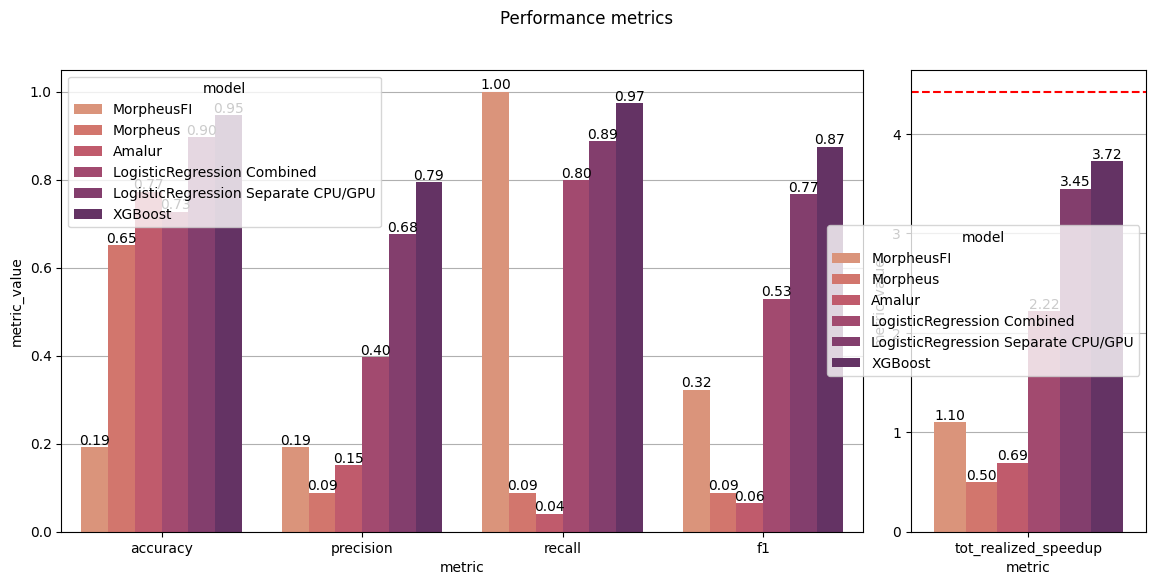

In [ ]:
full_eval(X_test, y_test, test)

Model <class 'src.estimators.MorpheusFI'>, test cols: Index(['morpheusfi_p', 'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns',
       'morpheusfi_nis'],
      dtype='object')
Model <class 'src.estimators.Morpheus'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')
Model <class 'src.estimators.Amalur'>, test cols: Index(['cardinality_S', 'cardinality_T', 'comp_lmm_fac', 'comp_lmm_mat',
       'comp_ratio', 'comp_scalar_dense', 'fr', 'mem_write_rowsum',
       'nnz_S_sum', 'nnz_T', 'operator', 'r_T', 'c_T', 'selectivity',
       'sparsity_T', 'tr', 'gpu_memory_bandwidth', 'gpu_cores',
       'gpu_clock_speed'],
      dtype='object')
Model <class 'sklearn.pipeline.Pipeline'>, test cols: Index(['cardinality_

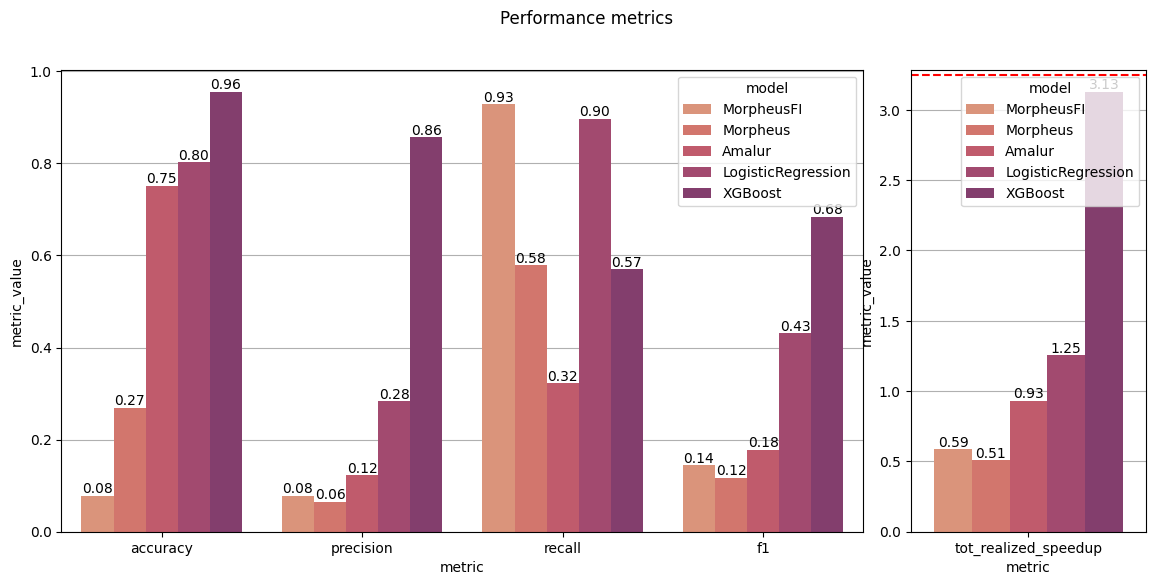

In [ ]:
X_validate, y_validate = validate[model_features], validate["label"]
full_eval(X_validate, y_validate, validate)